<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Imports and Functions

In [99]:
# imports and constants
import json
import pickle

import gmaps
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns

from IPython.display import display, HTML
import ipywidgets as widgets

# user imports
from utils.process_data import *
from utils.stats import *
from utils.lifesense_utils import *

%matplotlib inline

## Javascript

In [2]:
%%javascript
// ToC script
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [3]:
# Code hider, source: http://chris-said.io/2016/02/13/how-to-make-polished-jupyter-presentations-with-optional-code-visibility/
from IPython.display import HTML

HTML('''
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>
''')

## Load Data

In [4]:
baseline_df = pd.read_excel("ls_data/LS_Wave1_SC_BL_WK1_Data_081419-revised.xlsx",
                            sheet_name=0)

mapping_df = pd.read_csv("data_pull/Wave1LifeSenseEnroll_DATA_LABELS_2019-08-15_0929.csv")

redcap_dict = dict(zip(mapping_df['Case#:'], mapping_df['LifeSense Study App ID:    ']))

with open("data_pull/ids/wave1_ids.txt", "r") as internal_f:
    wave1_ids = [line.strip() for  line in internal_f.readlines()]

## Functions

In [416]:
def build_corr_mat(corrs, p_vals, labels, title, alpha, figsize=[20,12], vmin=-1, vmax=1):
    """
    returns the matplotlib plt object for the specified correlations.
    """
    plt.rcParams["figure.figsize"] = figsize
    plt.imshow(corrs, vmin=vmin, vmax=vmax)
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = "{0:.2f}".format(corrs[i, j])
            p = p_vals[i,j]
            if p < alpha:
                text = text + "*"
            plt.text(j,i, text, ha="center", va="center", color="w")
    plt.xticks([x for x in range(len(labels))], labels, rotation=45, ha="right", rotation_mode='anchor')
    plt.yticks([x for x in range(len(labels))], labels)
    plt.colorbar()
    plt.title(title)
    return plt


def filter_sig_corrs(r_corrs, r_p_vals, cols, target_col, filter_prefix="", alpha=0.05):
    """Builds a df with correlations for the target_col, optionally providing a prefix filter for columns
    
    """
    target_idx = np.where(cols==target_col)
    target_corrs = r_corrs[target_idx]
    target_p_vals = r_p_vals[target_idx]

    target_stats = np.transpose(np.vstack((target_corrs, target_p_vals)))
    target_df = pd.DataFrame(target_stats, index=cols, columns=['corr', 'p'])
    sig_features = target_df.loc[target_df['p'] < alpha]
    sig_features = sig_features.loc[sig_features.index.str.startswith(filter_prefix)]
    pd.options.display.float_format = '{:,.3f}'.format

    return sig_features.sort_values(by='p')


def build_partial_corr(corr_df, target, covar, pval=0.05):
    """
    Builds partial correlation DataFrame from corr_df of the target survey, controlling for covar.
    """
    
    partial_corr = pg.pairwise_corr(data=corr_df, covar=[covar], method='pearson')
    partial_corr = partial_corr.loc[(partial_corr['p-unc'] < pval) & (partial_corr['X'].str.contains(target)) & (~partial_corr['Y'].str.contains(target))]
    partial_corr['r_ctl'] = partial_corr['r']
    partial_corr['p_ctl'] = partial_corr['p-unc']

    partial_corr = partial_corr[['X', 'Y', 'covar', 'r_ctl', 'p_ctl']]

    pairwise_corr = pg.pairwise_corr(data=corr_df, method='pearson')
    pairwise_corr['r_unctl'] = pairwise_corr['r']
    pairwise_corr['p_unctl'] = pairwise_corr['p-unc']

    partial_corr = partial_corr.merge(pairwise_corr[['X', 'Y', 'r_unctl', 'p_unctl']], on=['X', 'Y'], how='left')
    return partial_corr

# Baseline State

## PHQ 8

- [PHQ-9 Self-report](http://med.stanford.edu/fastlab/research/imapp/msrs/_jcr_content/main/accordion/accordion_content3/download_256324296/file.res/PHQ9%20id%20date%2008.03.pdf)
- note that question 9 was omitted
- $\ge$ 10 is a positive screen for depression symptoms

**Scoring (PHQ 9 scale)**
- 1-4 Minimal depression
- 5-9 Mild depression
- 10-14 Moderate depression
- 15-19 Moderately severe depression
- 20-27 Severe depression 

In [6]:
init_df = pd.DataFrame()
init_df['study_id'] = baseline_df['study_id']
init_df['pid'] = init_df['study_id'].map(redcap_dict)
init_df['pid'] = init_df['pid'].astype(str)
init_df['pid'] = init_df['pid'].str.pad(width=8, side='left', fillchar='0')

In [7]:
init_df['phq8'] = baseline_df['phq_total_sc']
init_df['phq_q10'] = baseline_df['phq10_sc']

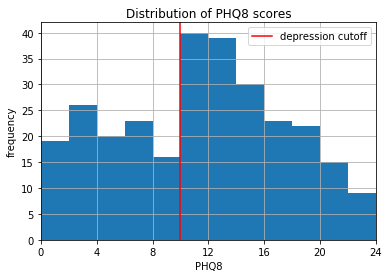

In [8]:
init_df['phq8'].hist(bins=12)
plt.xlim((0,24))
plt.xticks(np.arange(0,25,4))
plt.axvline(x=10, color='red', label="depression cutoff")
plt.xlabel("PHQ8")
plt.ylabel("frequency")
plt.title("Distribution of PHQ8 scores")
plt.legend()
plt.show()

In [9]:
init_df['is_depressed'] = init_df['phq8'] >= 10
init_df['is_depressed'].value_counts()

True     178
False    104
Name: is_depressed, dtype: int64

## Medical Diagnoses

- Has a mental health provider or physician ever diagnosed you with...
    - Major Depressive Disorder/Depression
    - Bipolar Disorder/Manic Depression/Mania
    - Obsessive-compulsive disorder
    - Post Traumatic Stress Disorder
    - Schizophrenia
    - Eating Disorders: anorexia or bulimia nervosa
    - Substance use disorder: alcohol or drugs
    
#### Responses

- 77: I don't know
- 99: Prefer not to answer

In [10]:
dx_cols = baseline_df.columns[baseline_df.columns.str.startswith('dx')]
init_df[dx_cols] = baseline_df[dx_cols]

In [11]:
init_df['dx_depression'].value_counts()

1     199
0      81
77      2
Name: dx_depression, dtype: int64

In [12]:
init_df['dx_ptsd'].value_counts()

0     209
1      66
77      7
Name: dx_ptsd, dtype: int64

## GAD

- [GAD7 self-report](mdcalc.com/gad-7-general-anxiety-disorder-7)

#### Scoring

- 5-9, Mild, Monitor
- 10-14, Moderate, Possible clinically significant condition
- \>15, Severe, Active treatment probably warranted
- $\ge$ 10 results in a positive screen for generalized anxiety disorder


In [13]:
init_df['gad7'] = baseline_df['gad_total']
init_df['gad_q8'] = baseline_df['gad08']

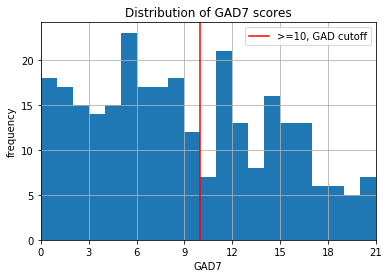

In [14]:
gad_df = init_df.loc[init_df['gad7'] <= 21]
gad_df['gad7'].hist(bins=21)
plt.xlim((0,21))
plt.xticks(np.arange(0,22,3))
plt.axvline(x=10, color='red', label=">=10, GAD cutoff")
plt.xlabel("GAD7")
plt.ylabel("frequency")
plt.title("Distribution of GAD7 scores")
plt.legend()
plt.show()

In [15]:
init_df['is_anxious'] = init_df['gad7'] >= 10
init_df['is_anxious'].value_counts()

False    166
True     116
Name: is_anxious, dtype: int64

## SHAPS

- [SHAPS self-report](https://www.phenxtoolkit.org/toolkit_content/PDF/PX710601.pdf)
- Snaith-Hamilton pleasure scale
    - can be used to measure anhedonia: a diminished or lack of ability to experience and anticipate pleasure
- $\ge$ 2 as anhedonia cutoff

In [16]:
init_df['shaps'] = baseline_df['shaps_score']

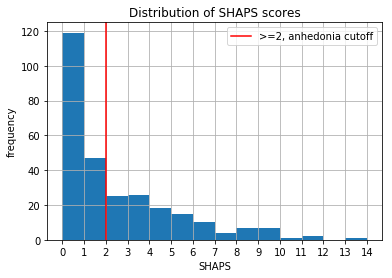

In [17]:
init_df['shaps'].hist(bins=14)
#plt.xlim((0,21))
plt.xticks(np.arange(0,15))
plt.axvline(x=2, color='red', label=">=2, anhedonia cutoff")
plt.xlabel("SHAPS")
plt.ylabel("frequency")
plt.title("Distribution of SHAPS scores")
plt.legend()
plt.show()

In [18]:
init_df['is_anhedonic'] = init_df['shaps'] >= 2

In [19]:
init_df['is_anhedonic'].value_counts()

False    166
True     116
Name: is_anhedonic, dtype: int64

## SPIN

- [SPIN self-report]
- social phobia inventory
- $\ge$ 20 indicator for social phobia

#### Scoring

- Less than 20 = None; 
- 21-30 = Mild; 
- 31-40 = Moderate; 
- 41-50 = Severe; 
- 51+ = Very Severe

#### SPIN subscales

- fear:
    - 1,3,5,10,14,15
- avoidance:
    - 4,6,8,9,10,11,16
- physiological:
    - 2,7,13,17
    
- mini-SPIN:
    - 6,9,15

In [20]:
init_df['spin'] = baseline_df['spin_totalscore']

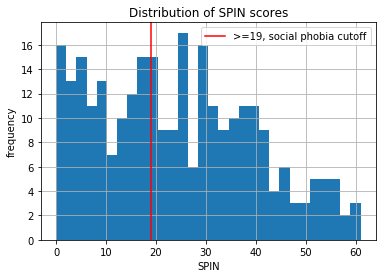

In [21]:
spin_df = init_df.loc[init_df['spin'] <= 100]
spin_df['spin'].hist(bins=30)
#plt.xlim((0,21))
#plt.xticks(np.arange(0,15))
plt.axvline(x=19, color='red', label=">=19, social phobia cutoff")
plt.xlabel("SPIN")
plt.ylabel("frequency")
plt.title("Distribution of SPIN scores")
plt.legend()
plt.show()

# SPIN Response Analysis

- only one PNA response on spin_01
- concerns about censorship/MNAR, [Gelman link](http://www.stat.columbia.edu/~gelman/arm/missing.pdf)

### Data Cleaning

In [22]:
spin_cols = baseline_df.columns[baseline_df.columns.str.contains('spin')][:-1]
#spin_df = init_df.copy()
#spin_df[spin_cols] = baseline_df[spin_cols]
spin_df = baseline_df[spin_cols]

In [23]:
spin_df[spin_df > 4].count(axis=0).sort_values(ascending=False)

spin_01    1
spin_08    0
spin_02    0
spin_03    0
spin_04    0
spin_05    0
spin_06    0
spin_07    0
spin_17    0
spin_16    0
spin_10    0
spin_11    0
spin_12    0
spin_13    0
spin_14    0
spin_15    0
spin_09    0
dtype: int64

In [24]:
spin_01_mean = spin_df.loc[spin_df['spin_01'] <= 4]['spin_01'].mean()

In [25]:
spin_df = spin_df.replace(to_replace=999, value=1)

### Subscale analysis

In [26]:
fear = [1,3,5,10,14,15]
avoid = [4,6,8,9,10,11,16]
physio = [2,7,13,17]
mini = [6,9,15]

def proc_spin_cols(qs):
    col_names = []
    for q in qs:
        name = "spin_0{}" if q < 10 else "spin_{}"
        col_names.append(name.format(q))
    return col_names

fear_cols = proc_spin_cols(fear)
avoid_cols = proc_spin_cols(avoid)
phys_cols = proc_spin_cols(avoid)
mini_cols = proc_spin_cols(mini)

In [27]:
spin_df['spin_fear'] = spin_df[fear_cols].sum(axis=1)
spin_df['spin_avoid'] = spin_df[avoid_cols].sum(axis=1)
spin_df['spin_phys'] = spin_df[phys_cols].sum(axis=1)
spin_df['spin_mini'] = spin_df[mini_cols].sum(axis=1)

In [28]:
init_df['spin_fear'] = spin_df['spin_fear']
init_df['spin_avoid'] = spin_df['spin_avoid']
init_df['spin_phys'] = spin_df['spin_phys']
init_df['spin_mini'] = spin_df['spin_mini']

In [29]:
spin_df.columns

Index(['spin_01', 'spin_02', 'spin_03', 'spin_04', 'spin_05', 'spin_06',
       'spin_07', 'spin_08', 'spin_09', 'spin_10', 'spin_11', 'spin_12',
       'spin_13', 'spin_14', 'spin_15', 'spin_16', 'spin_17', 'spin_fear',
       'spin_avoid', 'spin_phys', 'spin_mini'],
      dtype='object')

In [30]:
corr_df = spin_df.copy()
corr_df['spin_total'] = spin_df[spin_cols].sum(axis=1)
cols = ['spin_total', 'spin_fear', 'spin_avoid', 'spin_phys', 'spin_mini']
corr_df = corr_df[cols]

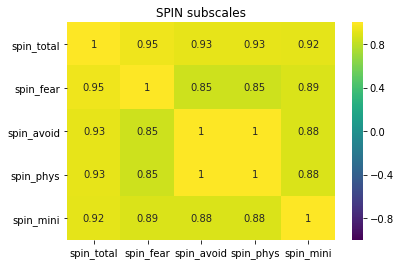

In [31]:
corr_df = corr_df.dropna()
#corr_df = corr_df.drop(['pid'], axis='columns')
corrs, _, p_vals = run_r_corr(corr_df, corr_type='pearson')
sns.heatmap(corrs, annot=True, vmin=-1, vmax=1, cmap="viridis")
plt.yticks(np.arange(0.5,len(cols)), cols, rotation='horizontal')
plt.xticks(np.arange(0.5,len(cols)), cols, rotation='horizontal')
#plt.xticks(np.arange(0.5, 5), np.arange(1,6))
plt.title("SPIN subscales")
plt.show()

### Factor Analysis

In [32]:
from sklearn.decomposition import FactorAnalysis

In [33]:
factor_transformer = FactorAnalysis(n_components=5, random_state=0)
spin_transformed = factor_transformer.fit_transform(spin_df)

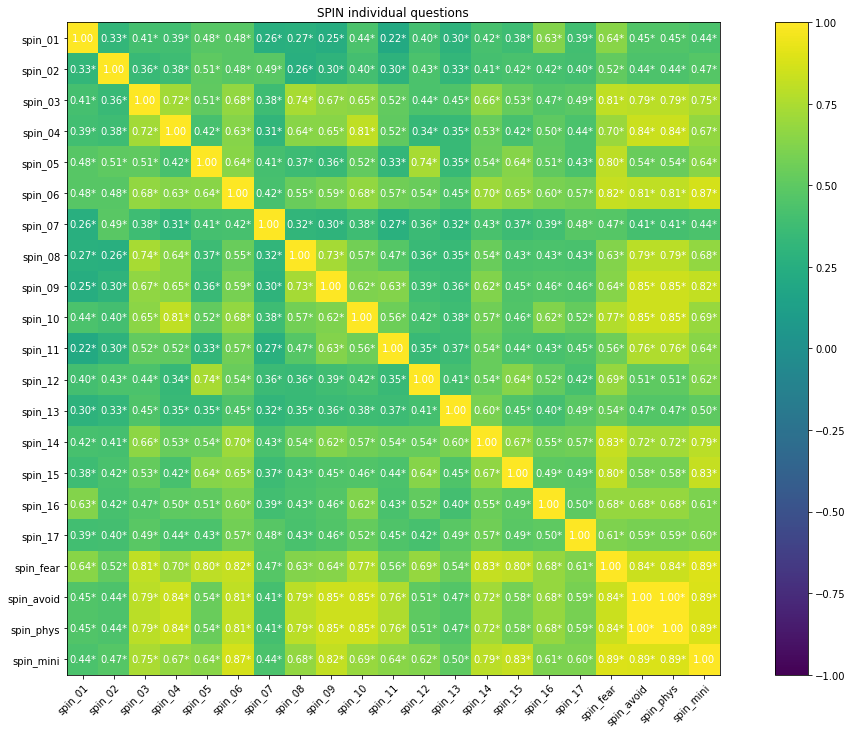

In [34]:
corr_df = spin_df.copy()
#corr_df = corr_df.dropna()
#corr_df = corr_df.drop(['pid'], axis='columns')
corrs, _, p_vals = run_r_corr(corr_df)
plt = build_corr_mat(corrs, p_vals, corr_df.columns.values, 'SPIN individual questions', 0.01, figsize=[20,12])
plt.show()


- [original SPIN paper factor analysis](https://www.cambridge.org/core/journals/the-british-journal-of-psychiatry/article/psychometric-properties-of-the-social-phobia-inventory-spin/9E4A3EE20D2B1A6C222CDB5807AC086A/core-reader): 5 factors

#### Questions

1. I am afraid of people in authority.
2. I am bothered by blushing in front of people.
3. Parties and social events scare me.
4. I avoid talking to people I don't know.
5. Being criticized scares me a lot.
6. Fear of embarrassment causes me to avoid doing things or speaking to people.
7. Sweating in front of people causes me distress.
8. I avoid going to parties.
9. I avoid activities in which I am the center of attention.
10. Talking to strangers scares me.
11. I avoid having to give speeches.
12. I would do anything to avoid being criticized.
13. Heart palpitations bother me when I am around people.
14. I am afraid of doing things when people might be watching.
15. Being embarrassed or looking stupid are my worst fears.
16. I avoid speaking to anyone in authority.
17. Trembling or shaking in front of others is distressing to me.

#### Comments

- Q1 and Q16 involve authority
- Q2, 7, 13, 17 involve physiological responses
- Q4, 10 involve strangers
- Q5, 12 involve criticism

In [35]:
np.sum(np.square(factor_transformer.components_), axis=1)

array([158.6355532 ,  13.93314885,   2.84102363,   0.68959581,
         0.91211388])

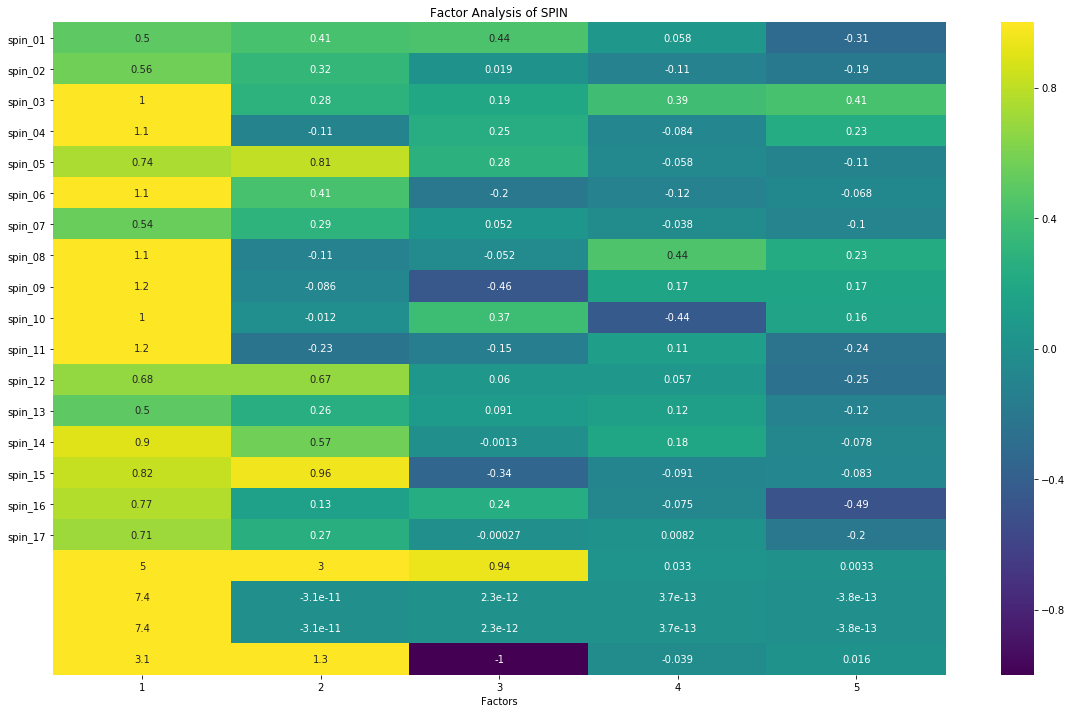

In [36]:
sns.heatmap(np.transpose(factor_transformer.components_), annot=True, vmin=-1, vmax=1, cmap="viridis")
plt.yticks(np.arange(0.5,17), spin_df.columns.values, rotation='horizontal')
plt.xticks(np.arange(0.5, 5), np.arange(1,6))
plt.xlabel("Factors")
plt.title("Factor Analysis of SPIN")
plt.show()

# Location Processing

In [37]:
test_id = "15565415"

In [41]:
keep_cols = ["time", "date", "pid"]

def extract_locs(row):
    """extracts location information from each row"""
    loc_df = pd.DataFrame()
    for i in range(9):
        # check for lat/long
        lat = "place-latitude-{}".format(i)
        if not pd.isnull(row[lat]):
            # we have a valid row
            row_dict = {}
            # populate metadata
            for col in keep_cols:
                row_dict[col] = row[col]
            # populate location attributes
            for attr in attributes:
                attr_name = "{}-{}".format(attr, i) 
                if attr_name in row.index and not pd.isnull(row[attr_name]):
                    row_dict[attr] = row[attr_name]
                else:
                    row_dict[attr] = np.nan
            series = pd.Series(row_dict)
            #print(series)
            loc_df = loc_df.append(series, ignore_index=True)
    return loc_df    

In [ ]:
semantic_locs = pd.DataFrame()
for i, row in even_df.iterrows():
    df = extract_locs(row)
    semantic_locs = semantic_locs.append(df)

In [ ]:
semantic_locs.head()

In [ ]:
sloc_cols = ['pid', 'date', 'time', 'place-kind', 'place-latitude', 'place-longitude']#, 'place-other', 'place-with-others']

sloc_df = semantic_locs[sloc_cols]

In [ ]:
sloc_df['place-kind'].value_counts()

In [ ]:
from geopy.distance import distance

In [ ]:
test_sloc = sloc_df.loc[sloc_df['pid'] == test_id]


In [ ]:
distance((loc_df.iloc[0]['latitude'], loc_df.iloc[0]['longitude']), (test_sloc.iloc[0]['place-latitude'], test_sloc.iloc[0]['place-longitude'])).m

In [ ]:
# 1000m as our radius
CLUSTER_RADIUS = 1000

In [ ]:
%%time

places = []

for i, loc_row in loc_df.iterrows():
    dist = CLUSTER_RADIUS + 5
    for j, sloc_row in test_sloc.iterrows():
        dist = distance((loc_row['latitude'], loc_row['longitude']), (sloc_row['place-latitude'], sloc_row['place-longitude'])).m
        if dist < CLUSTER_RADIUS:
            
            break
    if dist < CLUSTER_RADIUS:
        places.append(sloc_row['place-kind'])
    else:
        places.append(np.nan)

loc_df['place-kind'] = places

In [ ]:
%%time
def tag_locs(pid):
    print(pid)
    loc_df = pd.read_pickle("data_pull/pdk-location/{}.df".format(pid))
    if loc_df.shape[0] < 1:
        return 
    loc_df = format_time(loc_df)
    sloc_pid = sloc_df.loc[sloc_df['pid'] == pid]
    
    places = []

    for i, loc_row in loc_df.iterrows():

        dist = CLUSTER_RADIUS + 5
        for j, sloc_row in sloc_pid.iterrows():
            dist = distance((loc_row['latitude'], loc_row['longitude']), (sloc_row['place-latitude'], sloc_row['place-longitude'])).m
            if dist < CLUSTER_RADIUS:
                break
                
        if dist < CLUSTER_RADIUS:
            places.append(sloc_row['place-kind'])
        else:
            places.append(np.nan)

    loc_df['place-kind'] = places
    
    return loc_df[['pid', 'date', 'time', 'latitude', 'longitude', 'place-kind']]

In [ ]:
%%time

test = tag_locs(test_id)

In [ ]:
%%time

import multiprocessing

with multiprocessing.Pool(16) as pool:
    
    sloc_results = pool.map(tag_locs, wave1_ids)

In [ ]:
all_sloc_df = pd.DataFrame()

for df in sloc_results:
    all_sloc_df = all_sloc_df.append(df)

In [ ]:
all_sloc_df.to_pickle("ls_data/all_sloc.df")

In [ ]:
all_sloc_df['place-kind'].value_counts()

## Semantic Location Processing

### Semantic Locations Selected

- Food and Drink
- Home
- Work
- Gym/Exercise
- Another Person's Home
- Place of Worship
- Commute/Travel

### Transitions generation

In [52]:
all_sloc_df.head()

,pid,date,time,latitude,longitude,place-kind
0,08343773,2019-07-27,2019-07-27 12:15:00,41.7528,-91.6084,Food and Drink
0,08343773,2019-07-27,2019-07-27 12:21:00,41.7528,-91.6084,Food and Drink
0,08343773,2019-07-27,2019-07-27 12:26:11,41.7529,-91.6085,Food and Drink
0,08343773,2019-07-27,2019-07-27 12:32:11,41.7529,-91.6085,Food and Drink
0,08343773,2019-07-27,2019-07-27 12:37:11,41.7528,-91.6084,Food and Drink


In [53]:
sloc_map = {
    "Food and Drink" : "food",
    "Home" : "home",
    "Work" : "work",
    "Gym/Exercise" : "exercise",
    "Another Person's Home" : "anothers_home",
    "Place of Worship" : "religion",
    "Commute/Travel" : "travel",
    "Other..." : "other"
}

In [ ]:
all_sloc_df['place-kind-fmt'] = all_sloc_df['place-kind'].map(sloc_map)
all_sloc_df['place-kind-fmt'] = all_sloc_df['place-kind-fmt'].fillna('other')

In [ ]:
all_sloc_df['place-kind-fmt'].unique()

In [ ]:
sloc_transitions = pd.DataFrame()


def process_transition_hr(time, sloc_group):
    #sloc_pid = sloc_all_df.loc[sloc_all_df['pid'] == test_id]
    num_transitions = 0
    transition_dict = {}
    transition_dict['hr'] = time
    
    for sloc in sloc_map.values():
        transition_dict[sloc + '_dur'] = 0

    for sloc_i in sloc_map.values():
        for sloc_j in sloc_map.values():
            if sloc_i is not sloc_j:
                transition_dict[sloc_i + '_' + sloc_j] = 0
    
    cur_loc = sloc_group.iloc[0]['place-kind-fmt']
    cur_time = sloc_group.iloc[0]['time']
    for i, row in sloc_group.iterrows():
        next_loc = row['place-kind-fmt']
        next_time = row['time']
        if next_loc is not cur_loc:
            num_transitions += 1
            transition_dict[cur_loc + '_dur'] += (next_time - cur_time).total_seconds()
            transition_dict[cur_loc + '_' + next_loc] += 1
            cur_loc = next_loc
            cur_time = next_time
    
    # at the bottom of the hour
    transition_dict[cur_loc + '_dur'] += ((time + pd.Timedelta(1, unit='h')) - cur_time).total_seconds()
    
    transition_dict['tot_tansitions'] = num_transitions
    #print(transition_dict)
    return transition_dict

In [ ]:
%%time

all_sloc_df['hour'] = all_sloc_df['time'].dt.floor('H')


def build_sloc_hr(pid):
    print(pid)
    sloc_hr = pd.DataFrame()
    sloc_pid = all_sloc_df.loc[all_sloc_df['pid'] == pid]
    if sloc_pid.shape[0] < 1:
        return
    for time, group in sloc_pid.groupby("hour"):
        #print(group)
        sl = pd.DataFrame(process_transition_hr(time, group), index=[0])
        sloc_hr = sloc_hr.append(sl)

    sloc_hr = sloc_hr.set_index('hr')
    sloc_hr = sloc_hr.resample('1H').sum()
    sloc_hr = sloc_hr.reset_index()
    sloc_hr['pid'] = pid

    return sloc_hr

In [ ]:
%%time

import multiprocessing

with multiprocessing.Pool(16) as pool:
    
    sloc_hr_results = pool.map(build_sloc_hr, wave1_ids)

In [ ]:
sloc_hr_all = pd.DataFrame()

for df in sloc_hr_results:
    sloc_hr_all = sloc_hr_all.append(df)

In [ ]:
sloc_hr_all.to_pickle("ls_data/all_sloc_hr.df")

In [ ]:
sloc_hr_all.shape

## Location Durations

In [55]:
all_sloc_df = pd.read_pickle("ls_data/all_sloc.df")
sloc_hr_all = pd.read_pickle("ls_data/all_sloc_hr.df")
sloc_hr_all.head()

,hr,food_dur,home_dur,work_dur,exercise_dur,anothers_home_dur,religion_dur,travel_dur,other_dur,food_home,...,travel_other,other_food,other_home,other_work,other_exercise,other_anothers_home,other_religion,other_travel,tot_tansitions,pid
0,2019-07-27 12:00:00,2700.0,0.0,0.0,0.0,0.0,0,0,0.0,0,...,0,0,0,0,0,0,0,0,0,08343773
1,2019-07-27 13:00:00,1469.0,2120.0,0.0,0.0,0.0,0,0,0.0,1,...,0,0,0,0,0,0,0,0,1,08343773
2,2019-07-27 14:00:00,0.0,3500.0,0.0,0.0,0.0,0,0,0.0,0,...,0,0,0,0,0,0,0,0,0,08343773
3,2019-07-27 15:00:00,0.0,3320.0,0.0,0.0,0.0,0,0,0.0,0,...,0,0,0,0,0,0,0,0,0,08343773
4,2019-07-27 16:00:00,0.0,3205.0,0.0,0.0,0.0,0,0,0.0,0,...,0,0,0,0,0,0,0,0,0,08343773


In [56]:
dur_cols = list(sloc_hr_all.columns[sloc_hr_all.columns.str.contains("dur")].values)
dur_cols = ['pid', 'hr'] + dur_cols
sloc_dur_df = sloc_hr_all[dur_cols]
sloc_dur_df['date'] = sloc_dur_df['hr'].dt.floor('D')

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [57]:
sloc_dur_df = sloc_dur_df.loc[(sloc_dur_df['date'] >= '2019-07-31') & (sloc_dur_df['date'] <= '2019-08-02')]
mean_dur_df = sloc_dur_df.groupby(['pid', 'date'], as_index=False).sum()
mean_dur_df = mean_dur_df.groupby('pid', as_index=False).mean()

In [58]:
mean_dur_df.head()

,pid,food_dur,home_dur,work_dur,exercise_dur,anothers_home_dur,religion_dur,travel_dur,other_dur
0,00746649,0.0,26460.666667,10396.000000,0.0,4815.666667,0,0,25612.666667
1,01225297,0.0,52473.333333,8108.666667,0.0,0.000000,0,0,4541.666667
2,01254121,3879.0,35947.333333,4332.000000,0.0,0.000000,0,0,16779.666667
3,01495950,0.0,25604.333333,12278.333333,0.0,0.000000,0,0,530.666667
4,01766910,0.0,20196.333333,0.000000,0.0,11666.666667,0,0,272.000000


In [59]:
mean_dur_df.describe()

,food_dur,home_dur,work_dur,exercise_dur,anothers_home_dur,religion_dur,travel_dur,other_dur
count,273.000000,273.000000,273.000000,273.000000,273.000000,273.0,273.0,273.000000
mean,1031.606838,33048.822955,10370.339438,208.354090,1801.443223,0.0,0.0,13545.194750
std,2476.758598,21243.820546,11491.784460,732.268832,5103.108268,0.0,0.0,17961.741070
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
25%,0.000000,18827.666667,0.000000,0.000000,0.000000,0.0,0.0,3755.666667
50%,0.000000,35029.666667,5568.666667,0.000000,0.000000,0.0,0.0,7642.333333
75%,1277.000000,46475.666667,19701.666667,0.000000,0.000000,0.0,0.0,13710.333333
max,23627.000000,81930.666667,58888.000000,5321.000000,34816.333333,0.0,0.0,80738.333333


In [60]:
spin_dur = init_df[['pid', 'spin', 'gad7', 'phq8']]
spin_dur = spin_dur.merge(mean_dur_df, on='pid', how='left')

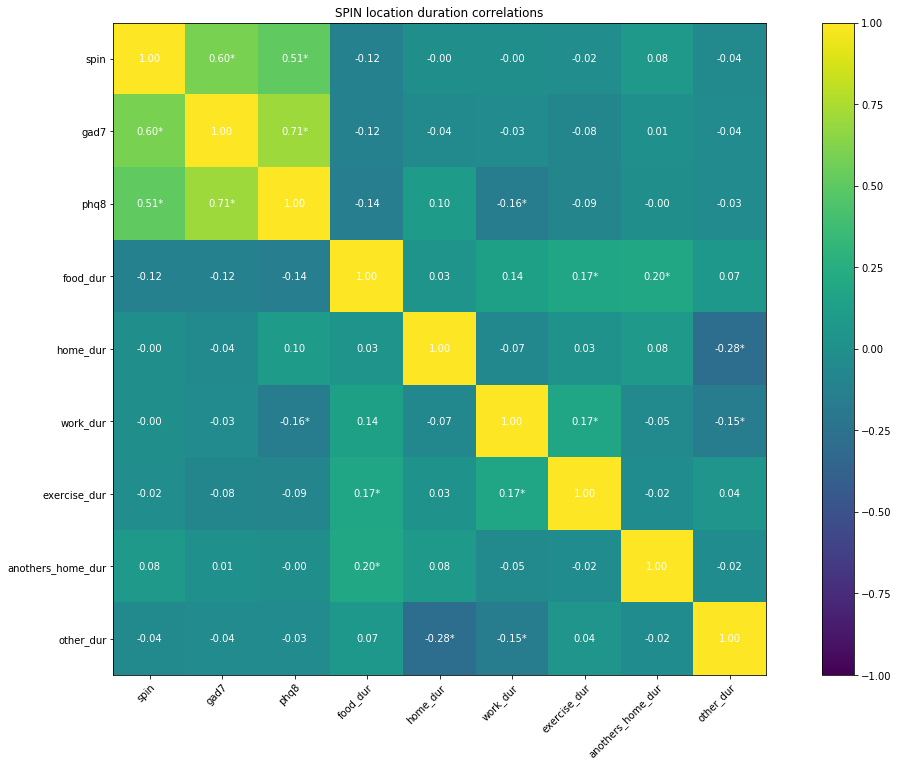

In [61]:
corr_df = spin_dur.copy()
corr_df = corr_df.dropna()
corr_df[dur_cols[2:]] = np.log(corr_df[dur_cols[2:]] + 1)

corr_df = corr_df.drop(['pid', 'religion_dur', 'travel_dur'], axis='columns')
corrs, _, p_vals = run_r_corr(corr_df)
plt = build_corr_mat(corrs, p_vals, corr_df.columns.values, 'SPIN location duration correlations', 0.05, figsize=[20,12])
plt.show()

### Correlations


In [62]:
spin_dur = init_df[['pid', 'spin', 'gad7', 'phq8']]
spin_dur[spin_cols] = spin_df[spin_cols]
spin_dur = spin_dur.merge(mean_dur_df, on='pid', how='left')

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [63]:
corr_df = spin_dur.copy()
corr_df = corr_df.dropna()
corr_df[dur_cols[2:]] = np.log(corr_df[dur_cols[2:]] + 1)
corr_df = corr_df.drop(['pid', 'religion_dur', 'travel_dur'], axis='columns')
corrs, _, p_vals = run_r_corr(corr_df)
filter_sig_corrs(corrs, p_vals, corr_df.columns.values, 'spin_02', alpha=1).iloc[19:]

,corr,p
anothers_home_dur,0.144,0.028
other_dur,-0.059,0.445
exercise_dur,0.052,0.507
food_dur,-0.026,0.763
work_dur,-0.010,0.915
home_dur,-0.009,0.924


In [64]:
filter_sig_corrs(corrs, p_vals, corr_df.columns.values, 'spin_08', alpha=1).iloc[19:]

,corr,p
work_dur,-0.141,0.032
other_dur,0.086,0.233
exercise_dur,-0.074,0.315
food_dur,-0.055,0.485
home_dur,-0.042,0.611
anothers_home_dur,0.033,0.705


In [65]:
filter_sig_corrs(corrs, p_vals, corr_df.columns.values, 'spin_15', alpha=1).iloc[19:]

,corr,p
food_dur,-0.171,0.008
other_dur,-0.083,0.253
work_dur,0.082,0.258
anothers_home_dur,0.022,0.799
home_dur,-0.011,0.906
exercise_dur,0.002,0.977


## Location Transitions

In [67]:
trans_cols = list(sloc_hr_all.columns[~sloc_hr_all.columns.str.contains("dur")].values)
sloc_trans_df = sloc_hr_all[trans_cols]
sloc_trans_df['date'] = sloc_trans_df['hr'].dt.floor('D')

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [69]:
sloc_trans_df = sloc_trans_df.loc[(sloc_trans_df['date'] >= '2019-07-31') & (sloc_trans_df['date'] <= '2019-08-02')]
mean_trans_df = sloc_trans_df.groupby(['pid', 'date'], as_index=False).sum()
mean_trans_df = mean_trans_df.groupby('pid', as_index=False).mean()

In [70]:
mean_trans_df.head()

,pid,food_home,food_work,food_exercise,food_anothers_home,food_religion,food_travel,food_other,home_food,home_work,...,travel_religion,travel_other,other_food,other_home,other_work,other_exercise,other_anothers_home,other_religion,other_travel,tot_tansitions
0,00746649,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,1.000,2.000,0.000,0.333,0.000,0.000,6.000
1,01225297,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.333,0.333,0.000,0.000,0.000,0.000,1.667
2,01254121,0.000,0.000,0.000,0.000,0.000,0.000,1.333,0.000,0.000,...,0.000,0.000,1.000,4.333,0.000,0.000,0.000,0.000,0.000,11.000
3,01495950,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.667,...,0.000,0.000,0.000,0.000,1.333,0.000,0.000,0.000,0.000,3.000
4,01766910,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.333,0.000,0.000,0.000,0.000,0.000,1.000


In [71]:
mean_trans_df.describe()

,food_home,food_work,food_exercise,food_anothers_home,food_religion,food_travel,food_other,home_food,home_work,home_exercise,...,travel_religion,travel_other,other_food,other_home,other_work,other_exercise,other_anothers_home,other_religion,other_travel,tot_tansitions
count,273.000,273.000,273.000,273.000,273.000,273.000,273.000,273.000,273.000,273.000,...,273.000,273.000,273.000,273.000,273.000,273.000,273.000,273.000,273.000,273.000
mean,0.055,0.026,0.004,0.010,0.000,0.000,0.220,0.051,0.049,0.013,...,0.000,0.000,0.208,1.139,0.556,0.065,0.153,0.000,0.000,4.668
std,0.187,0.113,0.035,0.090,0.000,0.000,0.453,0.183,0.210,0.087,...,0.000,0.000,0.409,1.387,0.909,0.235,0.551,0.000,0.000,4.329
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.333,0.000,0.000,0.000,0.000,0.000,1.667
50%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,1.000,0.333,0.000,0.000,0.000,0.000,4.000
75%,0.000,0.000,0.000,0.000,0.000,0.000,0.333,0.000,0.000,0.000,...,0.000,0.000,0.333,1.333,0.667,0.000,0.000,0.000,0.000,6.333
max,1.333,1.000,0.333,1.333,0.000,0.000,3.667,1.333,2.333,1.000,...,0.000,0.000,3.000,13.667,6.333,1.667,7.333,0.000,0.000,36.333


In [72]:
spin_trans = init_df[['pid', 'spin']]
spin_trans[spin_cols] = spin_df[spin_cols]
spin_trans = spin_trans.merge(mean_trans_df, on='pid', how='left')

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


### Correlations

In [74]:
corr_df = spin_trans.copy()
corr_df = corr_df.dropna()
corr_df[trans_cols[1:-1]] = np.log(corr_df[trans_cols[1:-1]] + 1)
corr_df = corr_df.drop(['pid'], axis='columns')
corrs, _, p_vals = run_r_corr(corr_df)
filter_sig_corrs(corrs, p_vals, corr_df.columns.values, 'spin_12', alpha=1).iloc[17:25]


,corr,p
other_work,0.167,0.023
other_food,-0.156,0.039
food_other,-0.142,0.071
work_other,0.134,0.090
food_exercise,-0.105,0.243
home_work,0.101,0.277
work_food,-0.100,0.279
anothers_home_home,-0.082,0.450


In [75]:
filter_sig_corrs(corrs, p_vals, corr_df.columns.values, 'spin_07', alpha=1).iloc[17:25]

,corr,p
anothers_home_other,0.166,0.024
other_anothers_home,0.138,0.079
food_anothers_home,0.138,0.080
anothers_home_work,0.096,0.311
food_work,0.079,0.474
other_work,0.076,0.501
work_food,0.072,0.540
exercise_other,-0.069,0.566


# EMAs

## Morning

In [76]:
morn_ema_df = pd.DataFrame()
all_ids = wave1_ids

for pid in all_ids:
    morn_df = pd.read_pickle("data_pull/morning_ema/{}.df".format(pid))
    morn_ema_df = morn_ema_df.append(morn_df, sort=True)

In [77]:
morn_ema_df['timestamp'] = morn_ema_df['timestamp'].astype(int)
morn_ema_df['timezone-offset'] = morn_ema_df['timezone-offset'].astype(int)
morn_ema_df['sleep-quality'] = morn_ema_df['sleep-quality'].astype(int)
morn_ema_df['mood'] = morn_ema_df['mood'].astype(int)

morn_ema_df['adj_ts'] = morn_ema_df['timestamp'] + morn_ema_df['timezone-offset']
morn_ema_df['date'] = pd.to_datetime(morn_ema_df['adj_ts'], unit='s').dt.floor('d')
morn_ema_df['pid'] = morn_ema_df['source']

In [78]:
morn_ema_cols = ['mood', 'sleep-quality', 'pid', 'date']
morn_emas = morn_ema_df[morn_ema_cols]

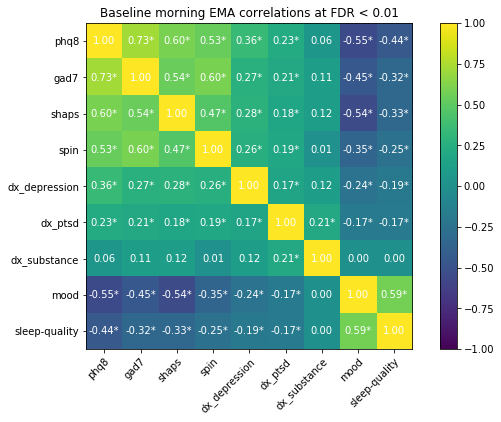

In [79]:
init_cols = ['phq8', 'gad7', 'shaps', 'spin', 'dx_depression', 'dx_ptsd', 'dx_substance']
init_df['pid'] = init_df['pid'].astype(str)
corr_df = init_df[init_cols + ['pid']].copy()
corr_df = corr_df.merge(morn_emas.groupby('pid').mean().reset_index(), on='pid', how='left')
corr_df = corr_df.dropna()
corr_df = corr_df.drop(['pid'], axis='columns')
corrs, _, p_vals = run_r_corr(corr_df)
plt = build_corr_mat(corrs, p_vals, corr_df.columns.values, 'Baseline morning EMA correlations at FDR < 0.01', 0.01, figsize=[10,6])
plt.show()

## Evening 

In [81]:
even_ema_df = pd.DataFrame()

for pid in wave1_ids:
    even_df = pd.read_pickle("data_pull/evening_ema/{}.df".format(pid))
    even_ema_df = even_ema_df.append(even_df, sort=True)

In [82]:
even_ema_df['timestamp'] = even_ema_df['timestamp'].astype(int)
even_ema_df['timezone-offset'] = even_ema_df['timezone-offset'].astype(int)

even_ema_df['adj_ts'] = even_ema_df['timestamp'] + even_ema_df['timezone-offset']
even_ema_df['date'] = pd.to_datetime(even_ema_df['adj_ts'], unit='s').dt.floor('d')
even_ema_df['pid'] = even_ema_df['source']

In [83]:
even_ema_df['timestamp'] = even_ema_df['timestamp'].astype(int)
even_ema_df['timezone-offset'] = even_ema_df['timezone-offset'].astype(int)

even_ema_df['adj_ts'] = even_ema_df['timestamp'] + even_ema_df['timezone-offset']
even_ema_df['date'] = pd.to_datetime(even_ema_df['adj_ts'], unit='s').dt.floor('d')
even_ema_df['pid'] = even_ema_df['source']
# adjust for yesterday surveys
even_ema_df['for_yesterday'] = even_ema_df['for_yesterday'].fillna(0)
even_ema_df['for_yesterday'] = even_ema_df['for_yesterday'].astype(int)
even_ema_df['adj_date'] = even_ema_df['date'] - pd.to_timedelta(even_ema_df['for_yesterday'], unit='D')

even_ema_df['mood'] = even_ema_df['mood'].astype(int)

In [84]:
even_ema_cols = ['mood', 'pid', 'date']
even_emas = even_ema_df[even_ema_cols]

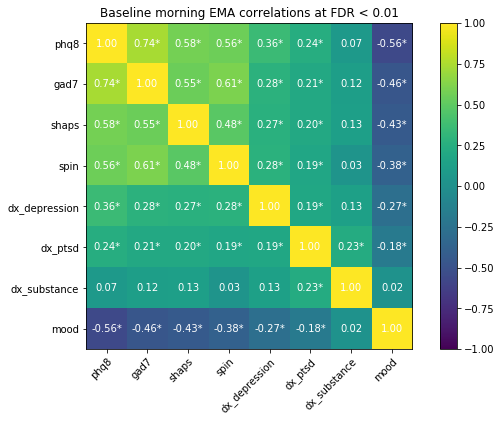

In [85]:
init_cols = ['phq8', 'gad7', 'shaps', 'spin', 'dx_depression', 'dx_ptsd', 'dx_substance']
init_df['pid'] = init_df['pid'].astype(str)
corr_df = init_df[init_cols + ['pid']].copy()
corr_df = corr_df.merge(even_emas.groupby('pid').mean().reset_index(), on='pid', how='left')
corr_df = corr_df.dropna()
corr_df = corr_df.drop(['pid'], axis='columns')
corrs, _, p_vals = run_r_corr(corr_df)
plt = build_corr_mat(corrs, p_vals, corr_df.columns.values, 'Baseline morning EMA correlations at FDR < 0.01', 0.01, figsize=[10,6])
plt.show()

In [86]:
ema_df = morn_emas.copy()
ema_df = ema_df.rename({'mood': 'morn_mood'}, axis='columns')
ema_df = ema_df.merge(even_emas, on=['pid', 'date'], how='left')
ema_df = ema_df.rename({'mood': 'even_mood'}, axis='columns')

## Evening PHQ8

In [462]:
even_phq8_df = pd.DataFrame()

for pid in all_ids:
    even_df = pd.read_pickle("data_pull/evening_phq8/{}.df".format(pid))
    even_phq8_df = even_phq8_df.append(even_df, sort=True)

In [463]:
even_phq8_df['timestamp'] = even_phq8_df['timestamp'].astype(int)
even_phq8_df['timezone-offset'] = even_phq8_df['timezone-offset'].astype(int)

even_phq8_df['adj_ts'] = even_phq8_df['timestamp'] + even_phq8_df['timezone-offset']
even_phq8_df['date'] = pd.to_datetime(even_phq8_df['adj_ts'], unit='s').dt.floor('d')
even_phq8_df['pid'] = even_phq8_df['source']
# adjust for yesterday surveys
even_phq8_df['for_yesterday'] = even_phq8_df['for_yesterday'].fillna(0)
even_phq8_df['for_yesterday'] = even_phq8_df['for_yesterday'].astype(int)
even_phq8_df['adj_date'] = even_phq8_df['date'] - pd.to_timedelta(even_phq8_df['for_yesterday'], unit='D')

In [467]:
# TODO process health status
#print(even_phq8_df.columns.values)
even_phq8_ema_cols = ['appetite', 'concentration', 'depression', 'difficulty', 'energy', 'feeling-bad', 
                      'mood', 'movement', 'pleasure', 'sleep', 'physical-health']
#even_phq8_ema_cols = ['mood', 'sleep']
even_phq8_df[even_phq8_ema_cols].head()
even_phq8_emas = even_phq8_df[even_phq8_ema_cols + ['pid']]
even_phq8_emas['pid'] = even_phq8_emas['pid'].astype(int)

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [468]:
even_phq8_emas

,appetite,concentration,depression,difficulty,energy,feeling-bad,mood,movement,pleasure,sleep,physical-health,pid
0,3,3,3,3,3,3,0,0,3,2,"[fatigue, muscle-aches]",8343773
0,1,2,3,2,3,3,2,1,3,3,[indigestion],18583649
0,1,2,2,1,1,1,6,1,2,2,"[headache, fatigue, muscle-aches, sinus-nasal]",31456993
0,1,1,1,1,0,1,3,0,1,0,"[headache, sinus-nasal]",1495950
0,1,1,1,1,3,1,6,1,1,3,"[muscle-aches, headache, fatigue]",69335292
0,3,2,3,3,3,3,5,1,1,3,"[muscle-aches, headache, fatigue, indigestion]",58780031
0,0,0,0,1,1,0,3,0,1,0,"[headache, fatigue]",59654069
0,1,1,1,1,2,1,6,0,1,2,[muscle-aches],76854891
0,3,1,1,1,2,1,3,0,1,1,"[muscle-aches, headache, fatigue, indigestion,...",53435128
0,1,1,1,1,1,0,7,0,0,2,[fatigue],77842251


# Daily State Statistics

## Load data

In [131]:
all_fga = pd.read_pickle("ls_data/all_fga.df")
all_scr = pd.read_pickle("ls_data/all_scr.df")
all_cal = pd.read_pickle("ls_data/all_cal.df")
all_sms = pd.read_pickle("ls_data/all_sms.df")
all_fus = pd.read_pickle("ls_data/all_fus.df")

all_sloc_df = pd.read_pickle("ls_data/all_sloc.df")
sloc_hr_all = pd.read_pickle("ls_data/all_sloc_hr.df")

## Foreground application and screen time

In [88]:
apps = [
    'katana',
    'orca', 
    'messaging',
    'launcher',
    'chrome',
    'email',
    'instagram',
    'youtube',
    'maps',
    'snapchat',
    'browser'
]

In [89]:
all_fga.head()

,hr,katana,orca,messaging,launcher,chrome,email,instagram,youtube,maps,snapchat,browser,pid
0,2019-07-27 12:00:00,"1,771.000",0.000,0.000,105.000,0.000,0.000,405.000,0.000,0.000,0.000,0.000,08343773
1,2019-07-27 13:00:00,"1,336.000",0.000,0.000,255.000,315.000,0.000,195.000,0.000,0.000,0.000,0.000,08343773
2,2019-07-27 14:00:00,"1,666.000",0.000,0.000,180.000,0.000,0.000,330.000,0.000,0.000,0.000,0.000,08343773
3,2019-07-27 15:00:00,"1,997.000",0.000,0.000,309.000,165.000,0.000,195.000,0.000,60.000,0.000,0.000,08343773
4,2019-07-27 16:00:00,"1,289.000",0.000,0.000,379.000,0.000,0.000,75.000,0.000,0.000,0.000,0.000,08343773


In [90]:
all_fga[apps] = all_fga[apps].clip(lower=0)
all_fga['date'] = all_fga['hr'].dt.floor('d')

In [91]:
fga_daily = all_fga.groupby(['pid', 'date']).sum()
fga_daily = fga_daily.reset_index()

In [92]:
fga_daily = fga_daily.loc[(fga_daily['date'] >= ema_df['date'].min()) & (fga_daily['date'] <= ema_df['date'].max())]

In [93]:
all_scr['date'] = all_scr['hr'].dt.floor('d')
scr_daily = all_scr.groupby(['pid', 'date']).sum()
scr_daily = scr_daily.reset_index()
scr_daily = scr_daily.loc[(scr_daily['date'] >= ema_df['date'].min()) & (scr_daily['date'] <= ema_df['date'].max())]

In [94]:
fga_daily = fga_daily.merge(scr_daily, on=['pid', 'date'], how='left')

In [159]:
fga_daily["is_wkday"] = (pd.to_datetime(fga_daily['date']).dt.dayofweek < 5).astype(float)
fga_daily.describe()
#fga_daily = fga_daily.loc[fga_daily['katana'] > 0]

,katana,orca,messaging,launcher,chrome,email,instagram,youtube,maps,snapchat,browser,duration,transitions,is_wkday
count,"2,481.000","2,481.000","2,481.000","2,481.000","2,481.000","2,481.000","2,481.000","2,481.000","2,481.000","2,481.000","2,481.000","2,447.000","2,447.000","2,481.000"
mean,"1,489.510",226.260,971.986,"2,376.241","1,871.144",47.241,473.198,935.700,401.342,97.198,181.079,"14,577.313",124.540,0.777
std,"2,750.172",925.241,"1,670.616","3,742.906","3,431.834",218.650,"1,192.351","3,762.191","1,331.965",419.194,776.265,"8,725.951",106.324,0.416
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.000,0.000,0.000,534.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,"8,081.500",51.000,1.000
50%,30.000,0.000,245.000,"1,300.000",631.000,0.000,0.000,0.000,0.000,0.000,0.000,"13,962.000",97.000,1.000
75%,"1,865.000",60.000,"1,219.000","2,831.000","2,232.000",0.000,216.000,60.000,105.000,0.000,0.000,"20,331.000",166.000,1.000
max,"20,526.000","14,697.000","19,975.000","58,938.000","40,185.000","3,947.000","15,024.000","58,634.000","21,205.000","5,759.000","15,499.000","52,721.000",853.000,1.000


### Correlations

In [160]:
init_df[spin_cols] = baseline_df[spin_cols]

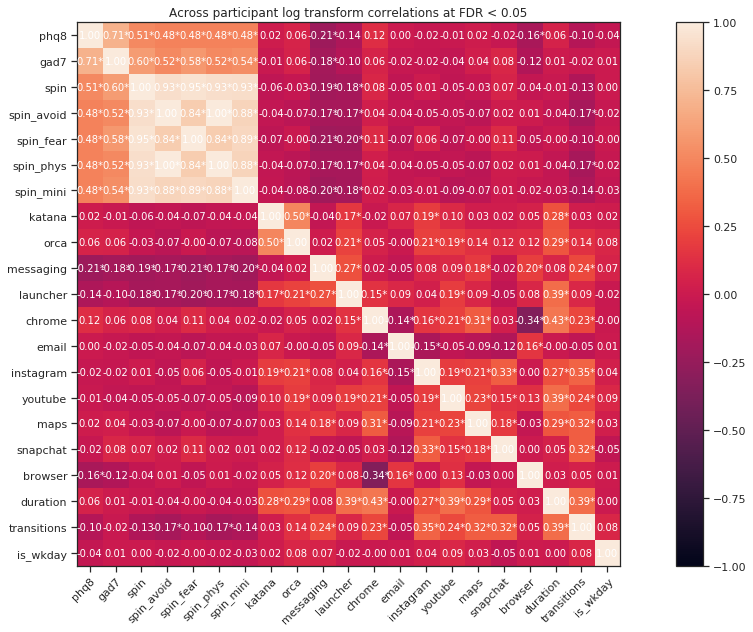

In [161]:
fga_mean = fga_daily.groupby('pid').mean()
fga_mean = np.log(fga_mean + 1)
init_cols = ['phq8', 'gad7', 'spin', 'spin_avoid', 'spin_fear', 'spin_phys', 'spin_mini']
corr_df = init_df[init_cols + ['pid']].copy()
corr_df['gad7'] = corr_df['gad7'].clip(upper=21)
corr_df = corr_df.merge(fga_mean, on='pid', how='left')
corr_df = corr_df.dropna()
corr_df = corr_df.drop(['pid'], axis='columns')
corrs, _, p_vals = run_r_corr(corr_df)
plt = build_corr_mat(corrs, p_vals, corr_df.columns.values, 'Across participant log transform correlations at FDR < 0.05', 0.05, figsize=[20,10])
plt.show()

### Partial correlations controlling for PHQ8

#### All days of week

In [162]:
# all days of week
build_partial_corr(corr_df, 'spin', 'phq8')

,X,Y,covar,r_ctl,p_ctl,r_unctl,p_unctl
0,spin,launcher,['phq8'],-0.163,0.007,-0.182,0.002
1,spin,duration,['phq8'],-0.142,0.018,-0.093,0.124
2,spin,transitions,['phq8'],-0.157,0.009,-0.175,0.004
3,spin_avoid,launcher,['phq8'],-0.167,0.005,-0.186,0.002
4,spin_avoid,maps,['phq8'],-0.134,0.026,-0.110,0.069
5,spin_avoid,browser,['phq8'],0.120,0.047,0.031,0.614
6,spin_avoid,duration,['phq8'],-0.176,0.003,-0.128,0.034
7,spin_avoid,transitions,['phq8'],-0.211,0.000,-0.223,0.000
8,spin_fear,launcher,['phq8'],-0.176,0.003,-0.194,0.001
9,spin_fear,duration,['phq8'],-0.143,0.017,-0.098,0.105


#### Weekdays

In [243]:
# weekdays

fga_wkday = fga_daily.loc[fga_daily['is_wkday'] == 1]
fga_mean_wkday = fga_wkday.groupby('pid').mean()
fga_mean_wkday = np.log(fga_mean_wkday + 1)
init_cols = ['phq8', 'gad7', 'spin', 'spin_avoid', 'spin_fear', 'spin_phys']
corr_df = init_df[init_cols + ['pid']].copy()
corr_df['gad7'] = corr_df['gad7'].clip(upper=21)
corr_df = corr_df.merge(fga_mean_wkday, on='pid', how='left')
corr_df = corr_df.dropna()
corr_df = corr_df.drop(['pid'], axis='columns')

build_partial_corr(corr_df, 'spin', 'phq8')

,X,Y,covar,r_ctl,p_ctl,r_unctl,p_unctl
0,spin,launcher,['phq8'],-0.163,0.007,-0.187,0.002
1,spin,duration,['phq8'],-0.141,0.019,-0.096,0.113
2,spin,transitions,['phq8'],-0.147,0.015,-0.167,0.006
3,spin_avoid,launcher,['phq8'],-0.172,0.004,-0.195,0.001
4,spin_avoid,maps,['phq8'],-0.135,0.025,-0.102,0.091
5,spin_avoid,duration,['phq8'],-0.175,0.004,-0.130,0.031
6,spin_avoid,transitions,['phq8'],-0.201,0.001,-0.215,0.000
7,spin_fear,launcher,['phq8'],-0.181,0.003,-0.203,0.001
8,spin_fear,snapchat,['phq8'],0.132,0.028,0.104,0.084
9,spin_fear,duration,['phq8'],-0.145,0.016,-0.103,0.088


#### Weekends

In [242]:
# weekends
fga_wkend = fga_daily.loc[fga_daily['is_wkday'] == 0]
fga_mean_wkend = fga_wkend.groupby('pid').mean()
fga_mean_wkend = np.log(fga_mean_wkend + 1)
init_cols = ['phq8', 'gad7', 'spin', 'spin_avoid', 'spin_fear', 'spin_phys']
corr_df = init_df[init_cols + ['pid']].copy()
corr_df = corr_df.merge(fga_mean_wkend, on='pid', how='left')
corr_df = corr_df.dropna()
corr_df = corr_df.drop(['pid'], axis='columns')

build_partial_corr(corr_df, 'spin', 'phq8')

,X,Y,covar,r_ctl,p_ctl,r_unctl,p_unctl
0,spin,launcher,['phq8'],-0.139,0.022,-0.155,0.010
1,spin,duration,['phq8'],-0.140,0.021,-0.100,0.100
2,spin,transitions,['phq8'],-0.191,0.002,-0.200,0.001
3,spin_avoid,orca,['phq8'],-0.122,0.045,-0.108,0.075
4,spin_avoid,launcher,['phq8'],-0.148,0.014,-0.164,0.007
5,spin_avoid,duration,['phq8'],-0.170,0.005,-0.131,0.031
6,spin_avoid,transitions,['phq8'],-0.237,0.000,-0.241,0.000
7,spin_fear,messaging,['phq8'],-0.136,0.025,-0.206,0.001
8,spin_fear,launcher,['phq8'],-0.149,0.014,-0.164,0.007
9,spin_fear,instagram,['phq8'],0.124,0.042,0.103,0.089


## Call and text

In [156]:
baseline_df['routine_slabels09'].value_counts()

1    226
2     56
Name: routine_slabels09, dtype: int64

In [171]:
all_cal['date'] = all_cal['call_hour'].dt.floor('d')
cal_daily = all_cal.groupby(['pid', 'date']).sum()
cal_daily = cal_daily.reset_index()
cal_daily = cal_daily.loc[(cal_daily['date'] >= ema_df['date'].min()) & (cal_daily['date'] <= ema_df['date'].max())]

In [172]:
all_sms['date'] = all_sms['hour'].dt.floor('d')
sms_daily = all_sms.groupby(['pid', 'date']).sum()
sms_daily = sms_daily.reset_index()
sms_daily = sms_daily.loc[(sms_daily['date'] >= ema_df['date'].min()) & (sms_daily['date'] <= ema_df['date'].max())]

In [173]:
#comm_daily = scr_daily.merge(cal_daily, on=['pid', 'date'], how='left')
comm_daily = cal_daily.merge(sms_daily, on=['pid', 'date'], how='left')

comm_daily["is_wkday"] = (pd.to_datetime(comm_daily['date']).dt.dayofweek < 5).astype(float)

comm_mean = comm_daily.groupby('pid').mean()
comm_mean = np.log(comm_mean + 1)


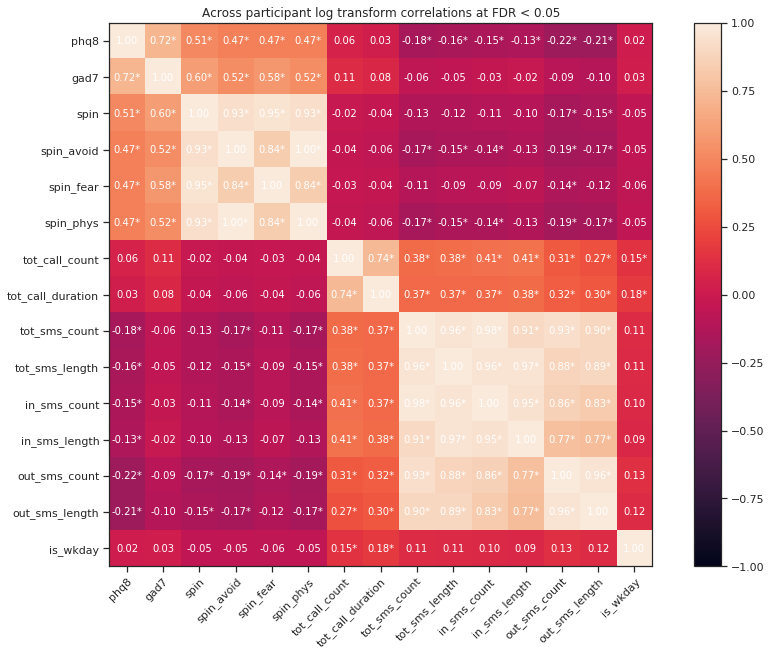

In [174]:
#init_cols = ['phq8', 'gad7', 'shaps', 'spin', 'dx_depression', 'dx_ptsd', 'dx_substance']
corr_df = init_df[init_cols + ['pid']].copy()
corr_df = corr_df.merge(comm_mean, on='pid', how='left')
corr_df = corr_df.dropna()
corr_df = corr_df.drop(['pid'], axis='columns')
corrs, _, p_vals = run_r_corr(corr_df)
plt = build_corr_mat(corrs, p_vals, corr_df.columns.values, 'Across participant log transform correlations at FDR < 0.05', 0.05, figsize=[15,10])
plt.show()

### Partial correlations controlling for PHQ8

#### All Days

In [175]:
# all days
build_partial_corr(corr_df, 'spin', 'phq8')

,X,Y,covar,r_ctl,p_ctl,r_unctl,p_unctl
0,spin_avoid,tot_call_duration,['phq8'],-0.141,0.021,-0.101,0.101
1,spin_avoid,tot_sms_length,['phq8'],-0.126,0.041,-0.158,0.010
2,spin_avoid,in_sms_length,['phq8'],-0.123,0.045,-0.141,0.022
3,spin_phys,tot_call_duration,['phq8'],-0.141,0.021,-0.101,0.101
4,spin_phys,tot_sms_length,['phq8'],-0.126,0.041,-0.158,0.010
5,spin_phys,in_sms_length,['phq8'],-0.123,0.045,-0.141,0.022


#### Weekdays

In [415]:
# weekdays
comm_wkday = comm_daily.loc[comm_daily['is_wkday'] == 1]
comm_mean_wkday = comm_wkday.groupby('pid').mean()
comm_mean_wkday = np.log(comm_mean_wkday + 1)

corr_df = init_df[init_cols + ['pid']].copy()
corr_df = corr_df.merge(comm_mean_wkday, on='pid', how='left')
corr_df = corr_df.dropna()
corr_df = corr_df.drop(['pid'], axis='columns')

build_partial_corr(corr_df, 'spin', 'phq8')

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/pingouin/pairwise.py:1097: RuntimeWarning: divide by zero encountered in arctanh
  stats['z'] = np.round(np.arctanh(stats['r'].values), 3)


,X,Y,covar,r_ctl,p_ctl,r_unctl,p_unctl
0,spin,tot_call_count,['phq8'],-0.051,0.408,-0.008,0.901
1,spin,tot_call_duration,['phq8'],-0.095,0.123,-0.049,0.422
2,spin,tot_sms_count,['phq8'],-0.043,0.489,-0.112,0.069
3,spin,tot_sms_length,['phq8'],-0.050,0.415,-0.096,0.117
4,spin,in_sms_length,['phq8'],-0.046,0.458,-0.077,0.213
5,spin,out_sms_count,['phq8'],-0.061,0.320,-0.152,0.013
6,spin,out_sms_length,['phq8'],-0.082,0.184,-0.147,0.017
7,spin_avoid,tot_call_count,['phq8'],-0.085,0.169,-0.041,0.504
8,spin_avoid,tot_call_duration,['phq8'],-0.144,0.019,-0.097,0.116
9,spin_avoid,tot_sms_count,['phq8'],-0.074,0.227,-0.135,0.028


#### Weekends

In [240]:
# weekdays
comm_wkend = comm_daily.loc[comm_daily['is_wkday'] == 0]
comm_mean_wkend = comm_wkend.groupby('pid').mean()
comm_mean_wkend = np.log(comm_mean_wkend + 1)

corr_df = init_df[init_cols + ['pid']].copy()
corr_df = corr_df.merge(comm_mean_wkend, on='pid', how='left')
corr_df = corr_df.dropna()
corr_df = corr_df.drop(['pid'], axis='columns')

build_partial_corr(corr_df, 'spin', 'phq8')

,X,Y,covar,r_ctl,p_ctl,r_unctl,p_unctl
0,spin,tot_sms_count,['phq8'],-0.147,0.017,-0.187,0.002
1,spin,tot_sms_length,['phq8'],-0.172,0.005,-0.168,0.006
2,spin,in_sms_count,['phq8'],-0.131,0.033,-0.164,0.008
3,spin,in_sms_length,['phq8'],-0.159,0.010,-0.144,0.019
4,spin,out_sms_count,['phq8'],-0.131,0.033,-0.202,0.001
5,spin,out_sms_length,['phq8'],-0.141,0.023,-0.178,0.004
6,spin_avoid,tot_sms_count,['phq8'],-0.200,0.001,-0.231,0.000
7,spin_avoid,tot_sms_length,['phq8'],-0.215,0.000,-0.208,0.001
8,spin_avoid,in_sms_count,['phq8'],-0.187,0.002,-0.211,0.001
9,spin_avoid,in_sms_length,['phq8'],-0.203,0.001,-0.186,0.002


## Fused Location

In [182]:
fus_daily = all_fus.loc[(all_fus['date'] >= ema_df['date'].min()) & (all_fus['date'] <= ema_df['date'].max())]

fus_daily['norm_entropy'] = fus_daily['entropy'] / np.log(fus_daily['cluster'] + 1)
fus_daily["is_wkday"] = (pd.to_datetime(fus_daily['date']).dt.dayofweek < 5).astype(float)

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


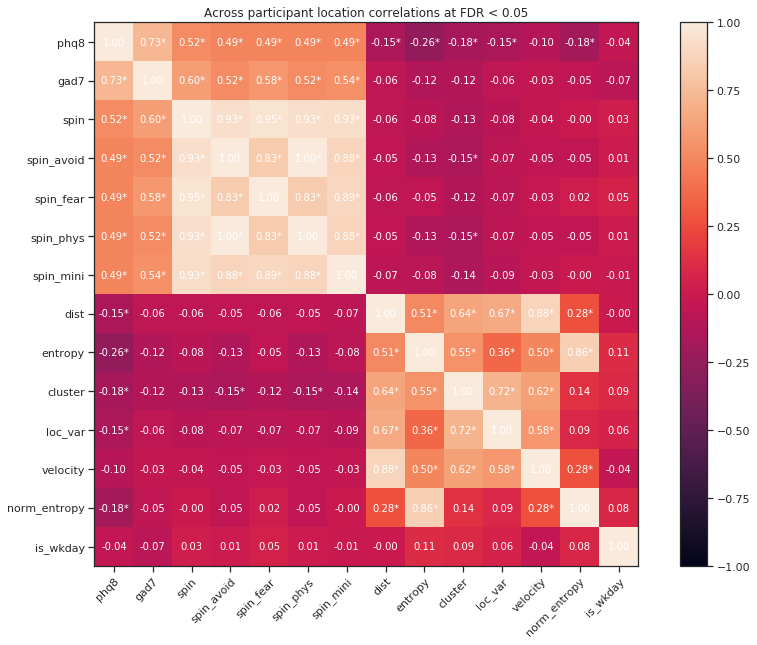

In [183]:
fus_mean = fus_daily.groupby('pid').mean()

init_cols = ['phq8', 'gad7', 'spin', 'spin_avoid', 'spin_fear', 'spin_phys', 'spin_mini']

corr_df = init_df[init_cols + ['pid']].copy()
corr_df = corr_df.merge(fus_mean, on='pid', how='left')
corr_df = corr_df.replace([np.inf, -np.inf], np.nan)
corr_df = corr_df.dropna()
corr_df = corr_df.drop(['pid'], axis='columns')
corrs, _, p_vals = run_r_corr(corr_df)
plt = build_corr_mat(corrs, p_vals, corr_df.columns.values, 'Across participant location correlations at FDR < 0.05', 0.05, figsize=[15,10])
plt.show()

### Partial Correlations controlling for PHQ8

#### All days

In [184]:
build_partial_corr(corr_df, 'spin', 'phq8')

,X,Y,covar,r_ctl,p_ctl,r_unctl,p_unctl
0,spin_fear,norm_entropy,['phq8'],0.130,0.034,0.020,0.748


#### Weekday

In [244]:
fus_wkday = fus_daily[fus_daily['is_wkday'] == 1]
fus_mean_wkday = fus_wkday.groupby('pid').mean()

corr_df = init_df[init_cols + ['pid']].copy()
corr_df = corr_df.merge(fus_mean_wkday, on='pid', how='left')
corr_df = corr_df.replace([np.inf, -np.inf], np.nan)
corr_df = corr_df.dropna()
corr_df = corr_df.drop(['pid'], axis='columns')

build_partial_corr(corr_df, 'spin', 'phq8')

,X,Y,covar,r_ctl,p_ctl,r_unctl,p_unctl
0,spin,norm_entropy,['phq8'],0.124,0.043,0.018,0.765
1,spin_fear,norm_entropy,['phq8'],0.141,0.022,0.040,0.520


#### Weekend

In [245]:
fus_wkend = fus_daily[fus_daily['is_wkday'] == 0]
fus_mean_wkend = fus_wkend.groupby('pid').mean()

corr_df = init_df[init_cols + ['pid']].copy()
corr_df = corr_df.merge(fus_mean_wkend, on='pid', how='left')
corr_df = corr_df.replace([np.inf, -np.inf], np.nan)
corr_df = corr_df.dropna()
corr_df = corr_df.drop(['pid'], axis='columns')

build_partial_corr(corr_df, 'spin', 'phq8')

,covar,r_ctl,p_ctl,X,Y,r_unctl,p_unctl


## Semantic Location Duration

In [205]:
dur_cols = list(sloc_hr_all.columns[sloc_hr_all.columns.str.contains("dur")].values)
dur_cols = ['pid', 'hr'] + dur_cols
sloc_dur_df = sloc_hr_all[dur_cols]
sloc_dur_df['date'] = sloc_dur_df['hr'].dt.floor('D')

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [206]:
sloc_dur_df = sloc_dur_df.loc[(sloc_dur_df['date'] >= ema_df['date'].min()) & (sloc_dur_df['date'] <= ema_df['date'].max())]

sloc_dur_df["is_wkday"] = (pd.to_datetime(sloc_dur_df['date']).dt.dayofweek < 5).astype(float)
mean_dur_df = sloc_dur_df.groupby(['pid', 'date'], as_index=False).sum()
mean_dur_df = mean_dur_df.groupby('pid', as_index=False).mean()

In [207]:
spin_dur = init_df[['pid', 'spin', 'phq8', 'spin_avoid', 'spin_fear', 'spin_phys', 'spin_mini']]
spin_dur = spin_dur.merge(mean_dur_df, on='pid', how='left')

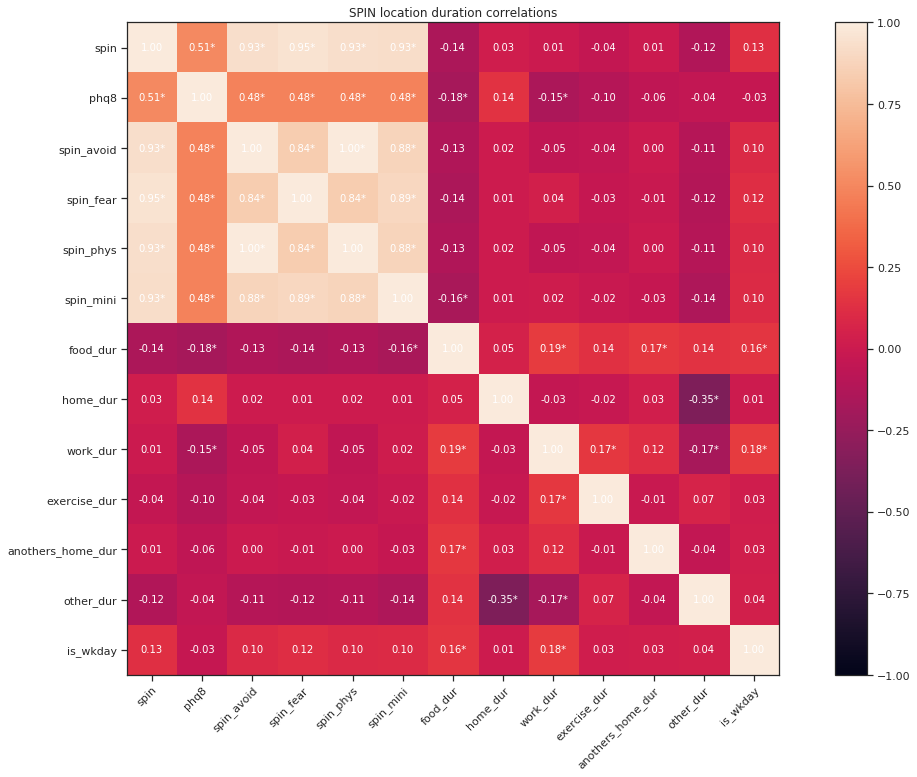

In [208]:
corr_df = spin_dur.copy()
corr_df = corr_df.dropna()
corr_df[dur_cols[2:]] = np.log(corr_df[dur_cols[2:]] + 1)

corr_df = corr_df.drop(['pid', 'religion_dur', 'travel_dur'], axis='columns')
corrs, _, p_vals = run_r_corr(corr_df)
plt = build_corr_mat(corrs, p_vals, corr_df.columns.values, 'SPIN location duration correlations', 0.05, figsize=[20,12])
plt.show()

### Partial Correlations controlling for PHQ8

#### All days

In [209]:
build_partial_corr(corr_df, 'spin', 'phq8')

,X,Y,covar,r_ctl,p_ctl,r_unctl,p_unctl
0,spin,other_dur,['phq8'],-0.135,0.026,-0.122,0.044
1,spin_avoid,other_dur,['phq8'],-0.149,0.013,-0.137,0.023
2,spin_fear,work_dur,['phq8'],0.126,0.038,0.031,0.615
3,spin_fear,other_dur,['phq8'],-0.141,0.020,-0.129,0.033
4,spin_phys,other_dur,['phq8'],-0.149,0.013,-0.137,0.023
5,spin_mini,other_dur,['phq8'],-0.184,0.002,-0.168,0.006


#### Weekdays

In [239]:
sloc_dur_wkday = sloc_dur_df.loc[sloc_dur_df['is_wkday'] == 1]
mean_dur_wkday = sloc_dur_wkday.groupby(['pid', 'date'], as_index=False).sum()
mean_dur_wkday = mean_dur_wkday.groupby('pid', as_index=False).mean()

spin_dur = init_df[['pid', 'spin', 'phq8', 'spin_avoid', 'spin_fear', 'spin_phys']]
spin_dur = spin_dur.merge(mean_dur_wkday, on='pid', how='left')
corr_df = spin_dur.copy()
corr_df = corr_df.dropna()
corr_df[dur_cols[2:]] = np.log(corr_df[dur_cols[2:]] + 1)

corr_df = corr_df.drop(['is_wkday'], axis='columns')

#corr_df = corr_df.drop(['pid', 'religion_dur', 'travel_dur'], axis='columns')

build_partial_corr(corr_df, 'spin', 'phq8')

,X,Y,covar,r_ctl,p_ctl,r_unctl,p_unctl
0,spin,work_dur,['phq8'],0.121,0.046,0.015,0.808
1,spin_avoid,other_dur,['phq8'],-0.135,0.025,-0.134,0.027
2,spin_fear,work_dur,['phq8'],0.141,0.020,0.039,0.524
3,spin_fear,other_dur,['phq8'],-0.121,0.046,-0.120,0.047
4,spin_phys,other_dur,['phq8'],-0.135,0.025,-0.134,0.027


#### Weekends

In [238]:
sloc_dur_wkday = sloc_dur_df.loc[sloc_dur_df['is_wkday'] == 0]
mean_dur_wkend = sloc_dur_wkday.groupby(['pid', 'date'], as_index=False).sum()
mean_dur_wkend = mean_dur_wkend.groupby('pid', as_index=False).mean()

spin_dur = init_df[['pid', 'spin', 'phq8', 'spin_avoid', 'spin_fear', 'spin_phys']]
spin_dur = spin_dur.merge(mean_dur_wkend, on='pid', how='left')
corr_df = spin_dur.copy()
corr_df = corr_df.dropna()
corr_df[dur_cols[2:]] = np.log(corr_df[dur_cols[2:]] + 1)

#corr_df = corr_df.drop(['pid', 'religion_dur', 'travel_dur'], axis='columns')

build_partial_corr(corr_df, 'spin', 'phq8')

,covar,r_ctl,p_ctl,X,Y,r_unctl,p_unctl


## Semantic Location Transitions

In [224]:
trans_cols = list(sloc_hr_all.columns[~sloc_hr_all.columns.str.contains("dur")].values)
sloc_trans_df = sloc_hr_all[trans_cols]
sloc_trans_df['date'] = sloc_trans_df['hr'].dt.floor('D')

/home/tliu/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [225]:
sloc_trans_df = sloc_trans_df.loc[(sloc_trans_df['date'] >= ema_df['date'].min()) & (sloc_trans_df['date'] <= ema_df['date'].max())]
sloc_trans_df["is_wkday"] = (pd.to_datetime(sloc_trans_df['date']).dt.dayofweek < 5).astype(float)

mean_trans_df = sloc_trans_df.groupby(['pid', 'date'], as_index=False).sum()
mean_trans_df = mean_trans_df.groupby('pid', as_index=False).mean()

In [217]:
mean_trans_df.describe()

,food_home,food_work,food_exercise,food_anothers_home,food_religion,food_travel,food_other,home_food,home_work,home_exercise,...,travel_other,other_food,other_home,other_work,other_exercise,other_anothers_home,other_religion,other_travel,tot_tansitions,is_wkday
count,274.000,274.000,274.000,274.000,274.000,274.000,274.000,274.000,274.000,274.000,...,274.000,274.000,274.000,274.000,274.000,274.000,274.000,274.000,274.000,274.000
mean,0.043,0.020,0.002,0.009,0.000,0.000,0.168,0.037,0.048,0.013,...,0.000,0.166,1.085,0.473,0.056,0.148,0.000,0.000,4.220,18.523
std,0.126,0.077,0.015,0.057,0.000,0.000,0.273,0.117,0.217,0.069,...,0.000,0.263,1.257,0.675,0.186,0.437,0.000,0.000,3.791,0.888
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,9.750
25%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.444,0.000,0.000,0.000,0.000,0.000,1.889,18.667
50%,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.889,0.278,0.000,0.000,0.000,0.000,3.667,18.667
75%,0.000,0.000,0.000,0.000,0.000,0.000,0.222,0.000,0.000,0.000,...,0.000,0.222,1.333,0.729,0.000,0.111,0.000,0.000,5.667,18.667
max,0.778,0.667,0.111,0.667,0.000,0.000,1.444,1.000,2.556,0.667,...,0.000,1.222,11.778,5.333,1.667,5.556,0.000,0.000,30.444,23.000


In [218]:
spin_trans = init_df[['pid', 'spin', 'phq8', 'spin_fear', 'spin_avoid', 'spin_phys', 'spin_mini']]
#spin_trans[spin_cols] = spin_df[spin_cols]
spin_trans = spin_trans.merge(mean_trans_df, on='pid', how='left')

### Partial Correlations Correcting for PHQ8

#### All days

In [153]:
corr_df = spin_trans.copy()
corr_df = corr_df.dropna()
corr_df[trans_cols[1:-1]] = np.log(corr_df[trans_cols[1:-1]] + 1)
corr_df = corr_df.drop(['pid'], axis='columns')

build_partial_corr(corr_df, 'spin', 'phq8')

,X,Y,covar,r_ctl,p_ctl,r_unctl,p_unctl
0,spin,other_work,['phq8'],0.121,0.046,0.071,0.246
1,spin_fear,other_work,['phq8'],0.138,0.023,0.089,0.144


#### Weekdays

In [229]:
sloc_trans_wkday = sloc_trans_df.loc[sloc_trans_df['is_wkday'] == 1]
mean_trans_df = sloc_trans_wkday.groupby(['pid', 'date'], as_index=False).sum()
mean_trans_df = mean_trans_df.groupby('pid', as_index=False).mean()

spin_trans = init_df[['pid', 'spin', 'phq8', 'spin_fear', 'spin_avoid', 'spin_phys']]
#spin_trans[spin_cols] = spin_df[spin_cols]
spin_trans = spin_trans.merge(mean_trans_df, on='pid', how='left')

corr_df = spin_trans.copy()
corr_df = corr_df.dropna()
corr_df[trans_cols[1:-1]] = np.log(corr_df[trans_cols[1:-1]] + 1)
corr_df = corr_df.drop(['pid', 'is_wkday'], axis='columns')

build_partial_corr(corr_df, 'spin', 'phq8')

,X,Y,covar,r_ctl,p_ctl,r_unctl,p_unctl
0,spin,other_work,['phq8'],0.129,0.032,0.065,0.288
1,spin_fear,work_other,['phq8'],0.146,0.016,0.066,0.274
2,spin_fear,other_work,['phq8'],0.155,0.010,0.092,0.131


#### Weekends

In [230]:
sloc_trans_wkday = sloc_trans_df.loc[sloc_trans_df['is_wkday'] == 0]
mean_trans_df = sloc_trans_wkday.groupby(['pid', 'date'], as_index=False).sum()
mean_trans_df = mean_trans_df.groupby('pid', as_index=False).mean()

spin_trans = init_df[['pid', 'spin', 'phq8', 'spin_fear', 'spin_avoid', 'spin_phys']]
#spin_trans[spin_cols] = spin_df[spin_cols]
spin_trans = spin_trans.merge(mean_trans_df, on='pid', how='left')

corr_df = spin_trans.copy()
corr_df = corr_df.dropna()
corr_df[trans_cols[1:-1]] = np.log(corr_df[trans_cols[1:-1]] + 1)
corr_df = corr_df.drop(['pid', 'is_wkday'], axis='columns')

build_partial_corr(corr_df, 'spin', 'phq8')

,covar,r_ctl,p_ctl,X,Y,r_unctl,p_unctl


# Prediction

In [452]:
np.random.seed(0)
pids = ema_df['pid'].unique()
np.random.shuffle(pids)
train_pids = pids[:200]
test_pids = pids[200:]

## Features

In [453]:
demo_df = pd.read_pickle("ls_data/all_demo.df")

baseline_df = pd.read_excel("data_pull/LS_Wave1_SC_BL_WK1_Data_081419-revised.xlsx",
                            sheet_name=0)

demo_df['gender'] = baseline_df['demo_gender']

In [454]:
demo_df.head()

,study_id,pid,age,marital_status,education,fam_income,ind_income,gender
0,601011,91048552,28,single,bachelors,5,5,1
1,601012,31456993,33,married,masters,4,4,0
2,601013,51735262,27,single,masters,4,4,0
3,601014,69452375,25,single,some_college,5,2,0
4,601015,28021601,58,divorced,masters,3,3,0


In [455]:
demo_df['fam_income'] = demo_df['fam_income'].astype('category')
demo_df['ind_income'] = demo_df['ind_income'].astype('category')
demo_df['gender'] = demo_df['gender'].astype('category')
demo_df = pd.get_dummies(demo_df)
demo_df = demo_df.drop('study_id', axis='columns')
demo_df['pid'] = demo_df['pid'].astype(str)

In [456]:
feature_df = init_df[['pid', 'spin', 'phq8']]
feature_df = feature_df.merge(demo_df, on='pid', how='left')
feature_df['spin'] = feature_df['spin'].replace(1056, 58)



feature_df = feature_df.dropna()

## Baseline

In [457]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, ElasticNetCV, SGDRegressor

train_data = feature_df.loc[feature_df['pid'].isin(train_pids)]
test_data = feature_df.loc[feature_df['pid'].isin(test_pids)]

train_data = train_data.drop('pid', axis='columns')
test_data = test_data.drop('pid', axis='columns')

train_X = train_data.drop('spin', axis='columns')
train_y = train_data['spin']

test_X = test_data.drop('spin', axis='columns')
test_y = test_data['spin']

In [458]:
mdl = RandomForestRegressor(n_estimators=10)
mdl.fit(train_X[['phq8']], train_y)
mdl.score(test_X[['phq8']], test_y)

0.008021363545032911

In [459]:
mdl = GradientBoostingRegressor()
mdl.fit(train_X, train_y)
mdl.score(test_X, test_y)

-0.11742494391231072

In [460]:
mdl = LinearRegression()
mdl.fit(train_X[['phq8']], train_y)
mdl.score(test_X[['phq8']], test_y)

0.33518537589763153

In [461]:
mdl = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], cv=5, random_state=0, max_iter=10000)
mdl.fit(train_X, train_y)
mdl.score(test_X, test_y)

0.3536593635028211

## Sensor Features

In [444]:
comm_mean_wkday = comm_mean_wkday.add_suffix('_wkday')
comm_mean_wkend = comm_mean_wkend.add_suffix('_wkend')

feature_df = feature_df.merge(comm_mean_wkday, on='pid', how='left')
feature_df = feature_df.merge(comm_mean_wkend, on='pid', how='left')

In [445]:
fga_mean_wkday = fga_mean_wkday.add_suffix('_wkday')
fga_mean_wkend = fga_mean_wkend.add_suffix('_wkend')

feature_df = feature_df.merge(fga_mean_wkday, on='pid', how='left')
feature_df = feature_df.merge(fga_mean_wkend, on='pid', how='left')

In [446]:
fus_mean_wkday = fus_mean_wkday.add_suffix('_wkday')
fus_mean_wkend = fus_mean_wkend.add_suffix('_wkend')

feature_df = feature_df.merge(fus_mean_wkday, on='pid', how='left')
feature_df = feature_df.merge(fus_mean_wkend, on='pid', how='left')

In [447]:
feature_df = feature_df.replace([np.inf, -np.inf], np.nan)
feature_df = feature_df.fillna(0)

feature_df = feature_df.loc[:,~feature_df.columns.str.startswith('is_wkday')]

train_data = feature_df.loc[feature_df['pid'].isin(train_pids)]
test_data = feature_df.loc[feature_df['pid'].isin(test_pids)]

train_data = train_data.drop('pid', axis='columns')
test_data = test_data.drop('pid', axis='columns')

train_X = train_data.drop('spin', axis='columns')
train_y = train_data['spin']

test_X = test_data.drop('spin', axis='columns')
test_y = test_data['spin']

In [448]:
mdl = ElasticNetCV(cv=5, random_state=0)
mdl.fit(train_X, train_y)
mdl.score(test_X, test_y)

0.29850806523829754

In [449]:
mdl = GradientBoostingRegressor(learning_rate=0.05, subsample=0.6, max_features=5, random_state=0)
mdl.fit(train_X, train_y)
mdl.score(test_X, test_y)

0.04516552058620715

In [450]:
mdl = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], cv=5, random_state=0, max_iter=10000)
mdl.fit(train_X, train_y)
mdl.score(test_X, test_y)

0.33283062763597215

In [451]:
train_X.head()

,phq8,age,marital_status_divorced,marital_status_domestic_partnership,marital_status_dont_know,marital_status_live_with_partner,marital_status_married,marital_status_pna,marital_status_separated,marital_status_single,...,cluster_wkday_wkday_wkday,loc_var_wkday_wkday_wkday,velocity_wkday_wkday_wkday,norm_entropy_wkday_wkday_wkday,dist_wkend_wkend_wkend,entropy_wkend_wkend_wkend,cluster_wkend_wkend_wkend,loc_var_wkend_wkend_wkend,velocity_wkend_wkend_wkend,norm_entropy_wkend_wkend_wkend
0,3,28.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,...,10.000,-2.083,0.953,0.194,0.000,0.000,0.000,0.000,0.000,0.000
1,15,33.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,...,10.000,5.003,21.744,0.092,207.928,0.353,10.000,5.003,12.411,0.147
2,4,27.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,...,8.000,2.085,3.378,0.247,659.595,0.570,8.000,2.085,22.008,0.260
3,7,25.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,...,6.000,-4.837,1.768,0.243,61.515,0.575,6.000,-4.837,3.323,0.295
4,1,58.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,8.000,-3.465,4.787,0.208,75.011,0.416,8.000,-3.465,5.235,0.189


# Temporal Patterns

### Facebook Use

In [ ]:
fga_filter = all_fga.loc[(all_fga['date'] >= ema_df['date'].min()) & (all_fga['date'] <= ema_df['date'].max())]

In [ ]:
facebook_pivot = fga_filter.pivot(index='pid', columns='hr', values='katana')
pids = facebook_pivot.index

In [ ]:
depressed_dict = {k:v for k,v in zip(init_df['pid'], init_df['is_depressed'])}

In [ ]:
groups = ['blue' if depressed_dict.get(pid) else 'green' for pid in pids]

In [ ]:
facebook_pivot = facebook_pivot.fillna(0)

In [ ]:
cmap =  sns.color_palette("RdBu_r", 7)
sns.clustermap(facebook_pivot, col_cluster=False, cmap=cmap, center=0, row_colors=groups, robust=True)
#plt.title("Stress autocorrelation clusters")
#plt.ylabel("number of lags")
plt.show()

### Messages Use

In [ ]:
msg_pivot = fga_filter.pivot(index='pid', columns='hr', values='messaging')
pids = msg_pivot.index

In [ ]:
groups = ['blue' if depressed_dict.get(pid) else 'green' for pid in pids]

In [ ]:
msg_pivot = msg_pivot.fillna(0)

In [ ]:
cmap =  sns.color_palette("RdBu_r", 7)
sns.clustermap(msg_pivot, col_cluster=False, cmap=cmap, center=0, row_colors=groups, robust=True)
#plt.title("Stress autocorrelation clusters")
#plt.ylabel("number of lags")
plt.show()

#### Single day

In [ ]:
fga_single = all_fga.loc[all_fga['date'] == '2019-07-31']
msg_pivot = fga_single.pivot(index='pid', columns='hr', values='messaging')
pids = msg_pivot.index

In [ ]:
groups = ['blue' if depressed_dict.get(pid) else 'green' for pid in pids]

In [ ]:
msg_pivot = msg_pivot.fillna(0)

In [ ]:
cmap =  sns.color_palette("RdBu_r", 7)
sns.clustermap(msg_pivot, col_cluster=False, cmap=cmap, center=0, row_colors=groups, robust=True)
#plt.title("Stress autocorrelation clusters")
#plt.ylabel("number of lags")
plt.show()

### Morning EMAs

In [ ]:
ema_df = ema_df.drop_duplicates(subset=['pid', 'date'])
ema_filter = ema_df.loc[(ema_df['date'] >= '2019-07-31') & (ema_df['date'] <= '2019-08-05')]

In [ ]:
morn_pivot = ema_filter.pivot(index='pid', columns='date', values='morn_mood')
pids = morn_pivot.index

In [ ]:
groups = ['blue' if depressed_dict.get(pid) else 'green' for pid in pids]

In [ ]:
morn_pivot = morn_pivot.fillna(0)

In [ ]:
cmap =  sns.color_palette("RdBu_r", 7)
sns.clustermap(morn_pivot, col_cluster=False, cmap=cmap, center=0, row_colors=groups)
#plt.title("Stress autocorrelation clusters")
#plt.ylabel("number of lags")
plt.show()

### SMS

In [ ]:
sms_filter = all_sms.loc[(all_sms['date'] >= ema_df['date'].min()) & (all_sms['date'] <= ema_df['date'].max())]

In [ ]:
sms_pivot = sms_filter.pivot(index='pid', columns='hour', values='out_sms_count')
pids = sms_pivot.index

In [ ]:
depressed_dict = {k:v for k,v in zip(init_df['pid'], init_df['is_depressed'])}

In [ ]:
groups = ['blue' if depressed_dict.get(pid) else 'green' for pid in pids]

In [ ]:
sms_pivot = sms_pivot.fillna(0)

In [ ]:
cmap =  sns.color_palette("RdBu_r", 7)
sns.clustermap(sms_pivot, col_cluster=False, cmap=cmap, center=0, row_colors=groups, robust=True)
plt.title("Outgoing SMS count trends")
plt.show()

### Three days

In [ ]:
sms_filter = all_sms.loc[(all_sms['date'] >= '2019-07-31') & (all_sms['date'] <= '2019-08-02')]

In [ ]:
sms_pivot = sms_filter.pivot(index='pid', columns='hour', values='out_sms_count')
pids = sms_pivot.index

In [ ]:
depressed_dict = {k:v for k,v in zip(init_df['pid'], init_df['is_depressed'])}

In [ ]:
groups = ['blue' if depressed_dict.get(pid) else 'green' for pid in pids]

In [ ]:
sms_pivot = sms_pivot.fillna(0)

In [ ]:
cmap =  sns.color_palette("RdBu_r", 7)
sns.clustermap(sms_pivot, col_cluster=False, cmap=cmap, center=0, row_colors=groups, robust=True)
plt.title("Outgoing SMS count trends")
plt.show()